In [43]:
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Concatenate,Flatten, Dense, Dropout

%matplotlib inline
#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"


def Inception(inputs, units = 8, strides = 1):
    """
    naive google inception block
    """
    x1 = Conv2D(units, 5, padding='same', activation = 'relu', strides = strides)(inputs)
    x2 = Conv2D(units, 3, padding='same', activation = 'relu', strides = strides)(inputs)
    x3 = Conv2D(units, 1, padding='same', activation = 'relu', strides = strides)(inputs)
    outputs = Concatenate()([x1, x2, x3])    
    return outputs

    
def SinglePathClassificationModel(molmap_shape,  n_outputs = 1, strides = 1):
    """molmap_shape: w, h, c"""
    
    assert len(molmap_shape) == 3
    inputs = Input(molmap_shape)
    
    conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(inputs)
    
    conv1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(conv1) #p1
    
    incept1 = Inception(conv1, strides = 1, units = 32)
    
    incept1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(incept1) #p2
    
    incept2 = Inception(incept1, strides = 1, units = 64)
    
    #flatten
    flat1 = GlobalMaxPool2D()(incept2)   
    d1 = Dense(128,activation='tanh')(flat1)
    d1 = Dense(64,activation='tanh')(d1)
    
    outputs = Dense(n_outputs,activation='linear')(d1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [44]:
seed = 77
np.random.seed(seed)
tf.set_random_seed(seed)

In [45]:
df_train = pd.read_csv('../train.csv', index_col = 0)
df_valid = pd.read_csv('../valid.csv',  index_col = 0)
df_test = pd.read_csv('../test.csv',  index_col = 0)
df_etc = pd.read_csv('../etc.csv')
task = 'measured log solubility in mols per litre'
df_etc[task] = df_etc.Exp_LogS

In [46]:
len(df_train), len(df_valid), len(df_test), len(df_etc)

(901, 113, 113, 120)

In [47]:
df = df_train.append(df_valid).append(df_test).append(df_etc)
df = df.reset_index(drop=True)

train_idx = df.index[:len(df_train)]
valid_idx = df.index[len(df_train): len(df_train)+len(df_valid)]
test_idx = df.index[len(df_train)+len(df_valid): len(df_train)+len(df_valid) + len(df_test)]
etc_idx = df.index[-len(df_etc):]
len(train_idx), len(valid_idx), len(test_idx), len(etc_idx)

(901, 113, 113, 120)

In [48]:
# calculate feature
X1_name =  './X_descriptor.data'
X2_name =  './X_fingerprint.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp1 = loadmap('../../../descriptor_grid_split.mp')
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp2 = loadmap('../../../fingerprint_grid_split.mp')
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)

In [49]:
Y = df[[task]].values

trainX = X1[train_idx]
trainY = Y[train_idx]

validX = X1[valid_idx]
validY = Y[valid_idx]


testX = X1[test_idx]
testY = Y[test_idx]

etcX = X1[etc_idx]
etcY = Y[etc_idx]


In [50]:
from cbks import RegressionPerformance, EarlyStoppingAtMinLoss
molmap1_size = X1.shape[1:]
model = SinglePathClassificationModel(molmap1_size, n_outputs = Y.shape[1])

In [51]:
earlystop = EarlyStoppingAtMinLoss(patience=30, criteria = 'val_loss')
performace = RegressionPerformance((trainX, trainY), (validX, validY))
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = 'mse')

In [52]:
model.fit(trainX, trainY, batch_size=128, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) 

epoch: 0001, loss: 11.9928 - val_loss: 7.6152; rmse: 2.6929 - rmse_val: 2.7596;  r2: 0.1393 - r2_val: 0.0682                                                                                                    
epoch: 0002, loss: 5.8854 - val_loss: 4.2944; rmse: 2.1179 - rmse_val: 2.0723;  r2: 0.2212 - r2_val: 0.1447                                                                                                    
epoch: 0003, loss: 4.4443 - val_loss: 4.1081; rmse: 2.1288 - rmse_val: 2.0268;  r2: 0.2837 - r2_val: 0.2055                                                                                                    
epoch: 0004, loss: 4.5027 - val_loss: 4.0381; rmse: 2.0957 - rmse_val: 2.0095;  r2: 0.3166 - r2_val: 0.2399                                                                                                    
epoch: 0005, loss: 4.3556 - val_loss: 4.1057; rmse: 2.0783 - rmse_val: 2.0263;  r2: 0.3523 - r2_val: 0.2775                                                            

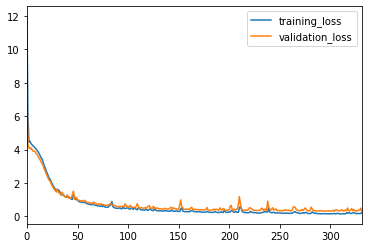

In [53]:
dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [54]:
performace.evaluate(trainX, trainY) # RMSE, R^2

([0.3881588738853565], [0.9684018480949267])

In [55]:
performace.evaluate(validX, validY) # RMSE, R^2

([0.5532972697532323], [0.9266626374078654])

In [56]:
performace.evaluate(testX, testY) # RMSE, R^2

([0.4799582762858571], [0.9400108218334348])

In [57]:
performace.evaluate(etcX, etcY)  # RMSE, R^2

([0.8109738607323443], [0.429108343674506])

In [58]:
dfr = df_etc[['Exp_LogS']].join(pd.DataFrame(performace.model.predict(etcX), columns= ['Pred_LogS']))
dfr.corr()

,Exp_LogS,Pred_LogS
Exp_LogS,1.000000,0.655064
Pred_LogS,0.655064,1.000000


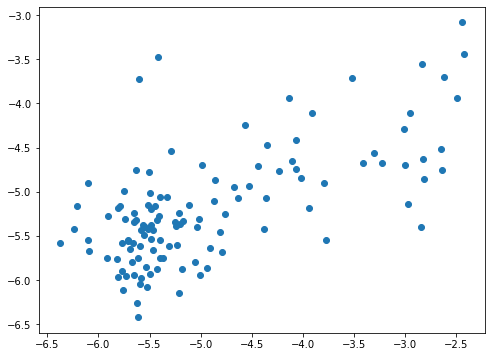

In [59]:
plt.figure(figsize = (8,6))
plt.scatter(dfr.Exp_LogS, dfr.Pred_LogS)